In [1]:
import csv
import os
import glob
import pandas as pd
import nltk
import string
import re
from nltk import ngrams
import multiprocessing
import time
import editdistance
import itertools
from collections import Counter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.width', 1000)


In [21]:
os.chdir("D://Scriptie//Data//lines//cleaned")
all_txt = glob.glob('*.txt')
all_txt = [f for f in all_txt if f[6:12] == 'leaned']

In [3]:
stopz = [word.split() for word in open("C:\\Users\\Ruben\\Documents\\Artikelen\\Joris\\stopwords-nl.txt", 'r', encoding = "utf-8").readlines()]
stopz = [item for sublist in stopz for item in sublist]

In [4]:
def Get_KWIC(search_term, start_year, end_year, window, dist):
    kwics_year = dict()
    
    for year in range(start_year, end_year+1):
    
        list_lines_year = list()

        files = [s for s in all_txt if str(year) in s]

        for file in files:
            lines = [line.rstrip('\n') for line in open(file, encoding = 'utf-8')]
            lines = [line for line in lines if search_term in line]
            
            #print(str(year) + ' occurences: ' + str(len(lines)))
            
            for line in lines:


                tmp_line = line.replace(search_term, '_'.join(search_term.split(' ')))


                line_tok = tmp_line.split(" ")
                positions = [idx for idx, s in enumerate(line_tok) if '_'.join(search_term.split(' ')) in s]

                for pos in positions:
                    p = int(pos)
                    ss = p - dist - window
                    se = p - dist
                    es = p + dist
                    ee = p + dist + window

                    if ss < 0:
                        se = 0
                    if ee > (len(line_tok) - 1):
                        ee = (len(line_tok) - 1)

                    selection = " ".join(line_tok[ss:se] + line_tok[es:ee])
                    list_lines_year.append(selection)
                    
            kwics_year.update({year:list_lines_year})
    
    kwic_df = pd.DataFrame()
    for key,value in kwics_year.items():
        for line in value:
            tmp = pd.DataFrame([line], columns = ['kwic'])
            tmp['year'] = key
            kwic_df = kwic_df.append(tmp)
    kwic_df = kwic_df.reset_index(drop=True)
    
    return kwic_df

In [39]:
def Get_KWICTW(search_term, start_year, end_year, window, dist):
    
    dft = Get_KWIC(search_term, start_year, end_year, window, dist)
    
    
    df_top = pd.DataFrame()
    for year in sorted(list(set(dft['year']))):
        ss = dft[dft['year'] == year]
        list_words = list(itertools.chain.from_iterable(ss.kwic.str.split(' ')))
        list_words = [w for w in list_words if w not in stopz]
        list_words = [w for w in list_words if w != '_'.join(search_term.split(' '))]
        list_words = Counter(list_words)
        
        for word, count in dict(list_words.most_common(30)).items():
            if count > 1:
                tmpdf = pd.DataFrame([word,count]).T
                tmpdf['year'] = year
                df_top = df_top.append(tmpdf)
        
            printdf = df_top[df_top.year == year]
        print(str(year) + " | " + '  '.join(list(printdf.iloc[0:13,0])))
    
    df_top.columns = ['word', 'count', 'year']
    df_top = df_top.pivot(index='word',columns='year')     
    df_top.columns = df_top.columns.get_level_values(0)
    df_top.columns = [str(year) for year in range(start_year, end_year + 1)]
    return df_top

In [ ]:
df = Get_KWICTW('buitenlandsche', 1815, 1914, 12, 0)

In [65]:
change_df = pd.DataFrame()

for i in range(1,(len(df.columns))):
    tmp = df.sort_values(df.columns[i], ascending = False)
    tmp = list(tmp.index[0:13])
    
    tmpp = df.sort_values(df.columns[i - 1], ascending = False)
    tmpp = list(tmpp.index[0:13])
    
    tmp = pd.DataFrame([len([word for word in tmp if word not in tmpp])])
    tmp['year'] = df.columns[i]
    change_df = change_df.append(tmp)
change_df.columns = ['c', 'y']

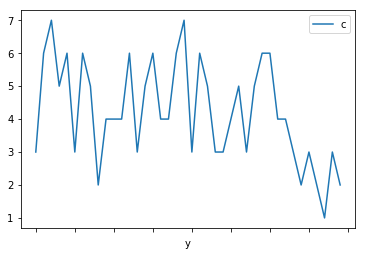

In [66]:
p = change_df.plot.line(x='y', y='c')
p

In [17]:
os.chdir("C:\\Users\\Ruben\\Documents\\Scriptie\\Data\\kwic_dfs")

df.to_csv('buitenlandsche_politiek_1850_1880_tw.csv', index = False)